# Web page engagement Prediction using Time series

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
df = pd.read_csv(r"D:\programming languages\datasets\google_usage.csv")
df

,Datetime,users_per_second
0,2006-12-31 01:00:00,5077.0
1,2006-12-31 02:00:00,4939.0
2,2006-12-31 03:00:00,4885.0
3,2006-12-31 04:00:00,4857.0
4,2006-12-31 05:00:00,4930.0
...,...,...
143201,2022-01-01 20:00:00,8401.0
143202,2022-01-01 21:00:00,8373.0
143203,2022-01-01 22:00:00,8238.0
143204,2022-01-01 23:00:00,7958.0


In [4]:
df['Datetime']

0         2006-12-31 01:00:00
1         2006-12-31 02:00:00
2         2006-12-31 03:00:00
3         2006-12-31 04:00:00
4         2006-12-31 05:00:00
                 ...         
143201    2022-01-01 20:00:00
143202    2022-01-01 21:00:00
143203    2022-01-01 22:00:00
143204    2022-01-01 23:00:00
143205    2022-01-02 00:00:00
Name: Datetime, Length: 143206, dtype: object

In [5]:
# converting dates into datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime']

0        2006-12-31 01:00:00
1        2006-12-31 02:00:00
2        2006-12-31 03:00:00
3        2006-12-31 04:00:00
4        2006-12-31 05:00:00
                 ...        
143201   2022-01-01 20:00:00
143202   2022-01-01 21:00:00
143203   2022-01-01 22:00:00
143204   2022-01-01 23:00:00
143205   2022-01-02 00:00:00
Name: Datetime, Length: 143206, dtype: datetime64[ns]

In [6]:
# Setting the "Datetime" column as an index
df.set_index('Datetime', inplace = True)

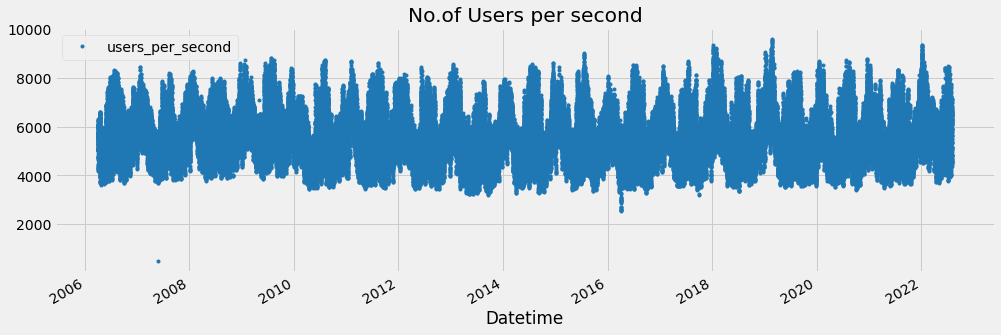

In [7]:
# visulizing the plot
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='No.of Users per second')
plt.show()

In [8]:
# removing outliers from the data
df = df[df.users_per_second >= df.users_per_second.mean() - 3 * df.users_per_second.std()]
df

,users_per_second
Datetime,
2006-12-31 01:00:00,5077.0
2006-12-31 02:00:00,4939.0
2006-12-31 03:00:00,4885.0
2006-12-31 04:00:00,4857.0
2006-12-31 05:00:00,4930.0
...,...
2022-01-01 20:00:00,8401.0
2022-01-01 21:00:00,8373.0
2022-01-01 22:00:00,8238.0


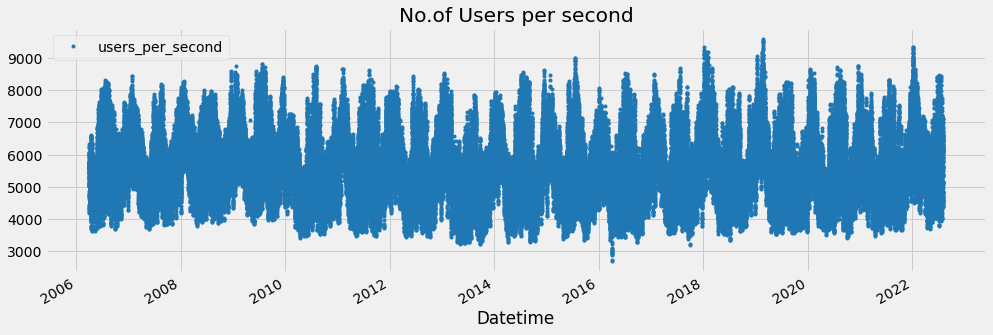

In [9]:
# again visualizing after removing outliers
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='No.of Users per second')
plt.show()

# Train / Test Split

In [10]:
# splitting the data for training and testing
train = df.loc[df.index < '2019-01-01']
test = df.loc[df.index >= '2019-01-01']

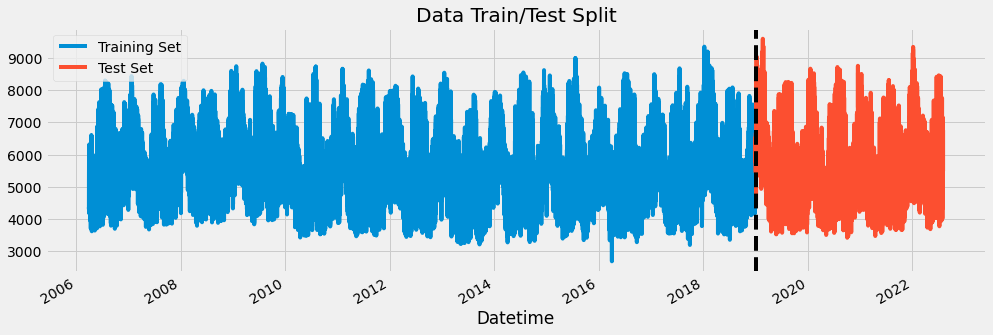

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [12]:
# considering the data of only one week
week_df = df.loc[(df.index > '01-04-2010') & (df.index < '01-11-2010')]

In [13]:
# function that return unique dates and their corresponding week days0
def get_unique_dates_and_weekdays(dataframe):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dates = dataframe.index.map(lambda t: t.date()).unique()
    week_days = [days[date.weekday()] for date in dates]
    return dates, week_days

In [14]:
"""
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dates1 = week_df.index.date
week_indexes = week_df.index.dayofweek
weekdays1 = [days[index] for index in week_indexes]
"""
dates, weekdays = get_unique_dates_and_weekdays(week_df)

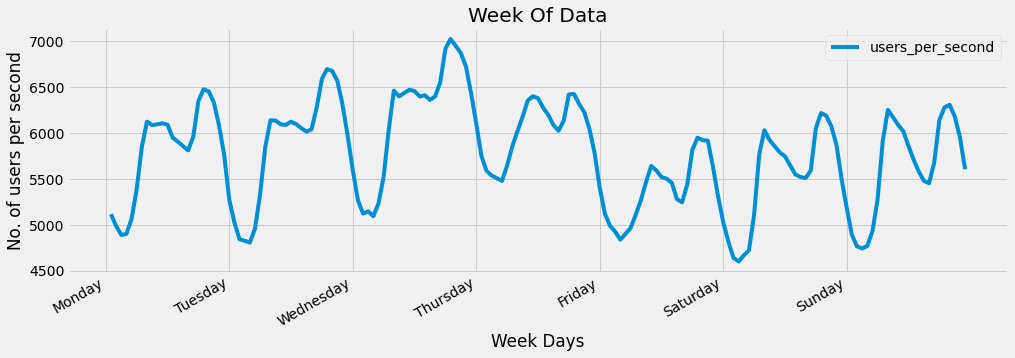

In [15]:
# visualizing one week data
week_df.plot(figsize=(15, 5), title='Week Of Data')
plt.xticks(dates, weekdays)
plt.xlabel("Week Days")
plt.legend()
plt.ylabel("No. of users per second")
plt.show()

# Feature Creation

In [16]:
# function to add new features(columns) to the dataframe
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [17]:
df

,users_per_second,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2006-12-31 01:00:00,5077.0,1,6,4,12,2006,365,31,52
2006-12-31 02:00:00,4939.0,2,6,4,12,2006,365,31,52
2006-12-31 03:00:00,4885.0,3,6,4,12,2006,365,31,52
2006-12-31 04:00:00,4857.0,4,6,4,12,2006,365,31,52
2006-12-31 05:00:00,4930.0,5,6,4,12,2006,365,31,52
...,...,...,...,...,...,...,...,...,...
2022-01-01 20:00:00,8401.0,20,5,1,1,2022,1,1,52
2022-01-01 21:00:00,8373.0,21,5,1,1,2022,1,1,52
2022-01-01 22:00:00,8238.0,22,5,1,1,2022,1,1,52


# Visualize our Feature / Target Relationship

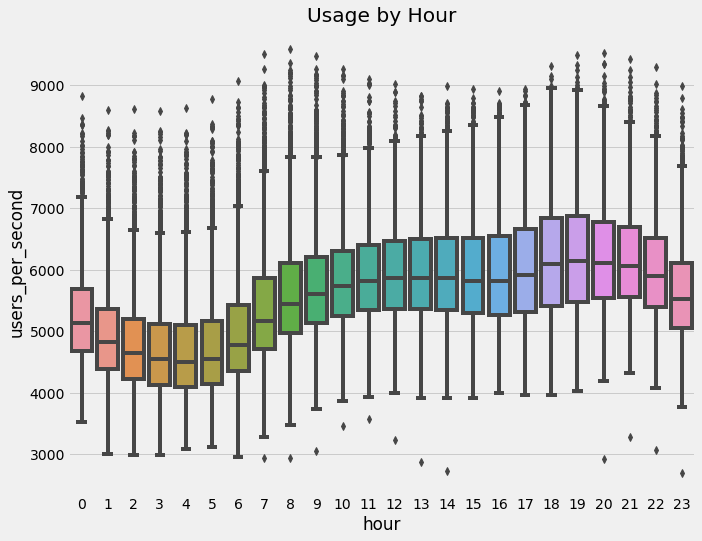

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='users_per_second')
ax.set_title('Usage by Hour')
plt.show()

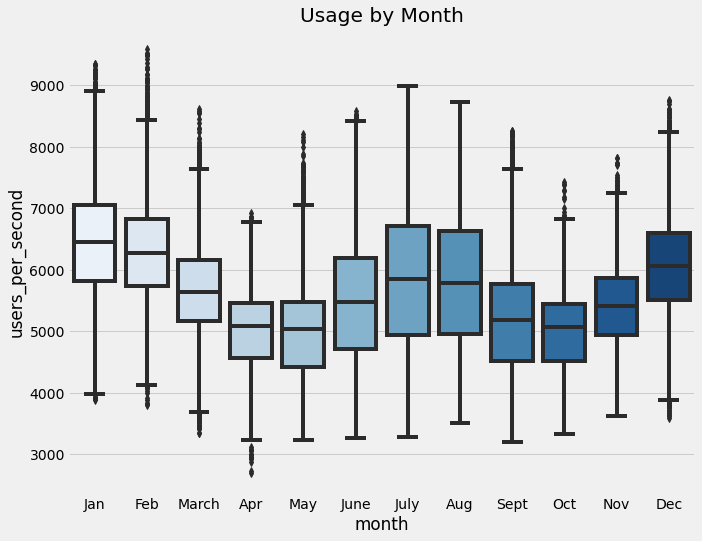

In [19]:
nums = [i for i in range(0, 12)]
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='users_per_second', palette='Blues')
ax.set_title('Usage by Month')
plt.xticks(nums, months)
plt.show()

# Create our Model

In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'users_per_second'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
# Initializing the model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.0075)
# Training the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[10:08:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5639.77230	validation_1-rmse:5663.50126
[50]	validation_0-rmse:3905.62625	validation_1-rmse:3921.59256
[100]	validation_0-rmse:2727.32727	validation_1-rmse:2746.62097
[150]	validation_0-rmse:1932.76011	validation_1-rmse:1963.28134
[200]	validation_0-rmse:1404.75813	validation_1-rmse:1449.90932
[250]	validation_0-rmse:1064.36882	validation_1-rmse:1122.41898
[300]	validation_0-rmse:850.99396	validation_1-rmse:924.80274
[350]	validation_0-rmse:723.04906	validation_1-rmse:813.95499
[400]	validation_0-rmse:647.20925	validation_1-rmse:750.18317
[450]	validation_0-rmse:602.27040	validation_1-rmse:714.32619
[500]	validation_0-rmse:574.97243	validation_1-rmse:694.66685
[550]	validation_0-rmse:557.13276	validation_1-rmse:683.16109
[600]	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0075, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

# Feature Importance

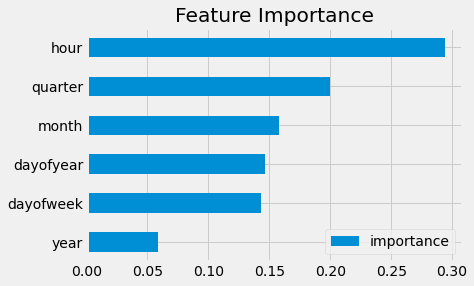

In [22]:
# Analyzing the importance of each feature
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [23]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df

,users_per_second,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2006-04-01 01:00:00,4374.0,1,5,2,4,2006,91,1,13,NaN
2006-04-01 02:00:00,4306.0,2,5,2,4,2006,91,1,13,NaN
2006-04-01 03:00:00,4322.0,3,5,2,4,2006,91,1,13,NaN
2006-04-01 04:00:00,4359.0,4,5,2,4,2006,91,1,13,NaN
2006-04-01 05:00:00,4436.0,5,5,2,4,2006,91,1,13,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-08-02 20:00:00,6545.0,20,1,3,8,2022,214,2,31,6543.208496
2022-08-02 21:00:00,6496.0,21,1,3,8,2022,214,2,31,6543.208496
2022-08-02 22:00:00,6325.0,22,1,3,8,2022,214,2,31,6471.074707


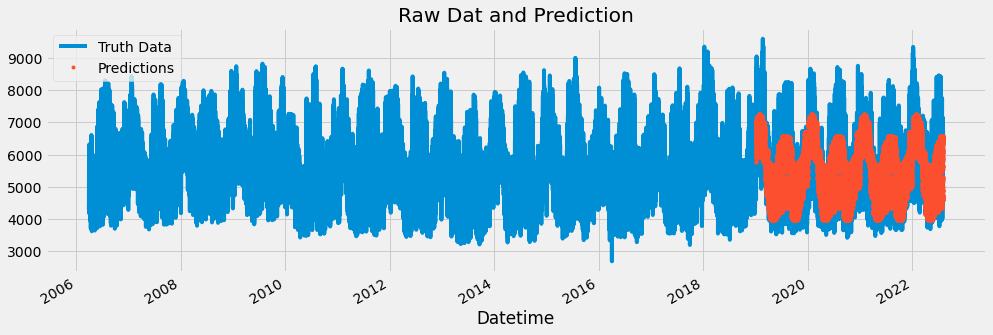

In [24]:
ax = df[['users_per_second']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

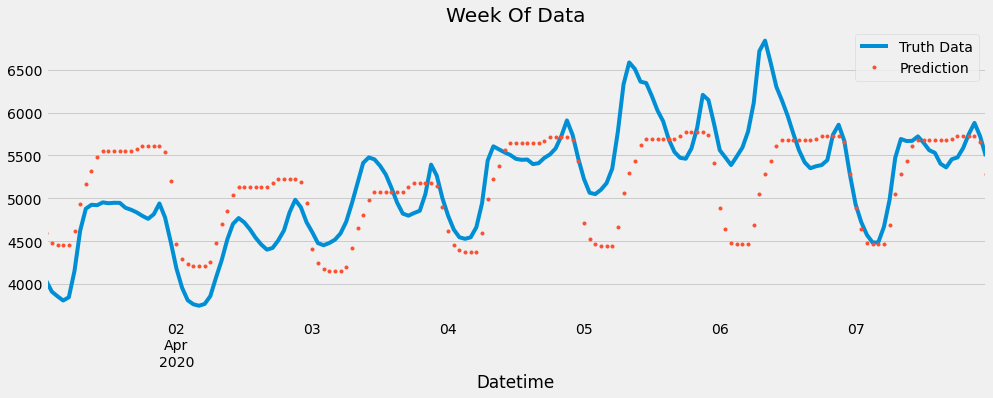

In [25]:
ax = df.loc[(df.index > '04-01-2020') & (df.index < '04-08-2020')]['users_per_second'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2020') & (df.index < '04-08-2020')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [26]:
score = np.sqrt(mean_squared_error(test['users_per_second'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 660.99


# Calculate Error
- Look at the worst and best predicted days

In [27]:
# Worst predictions
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-01-06    2234.768738
2019-02-20    2094.537618
2022-01-05    2059.618449
2019-02-16    1994.083252
2021-12-31    1977.494059
2019-02-19    1961.677511
2019-02-15    1947.003581
2021-02-24    1793.913818
2021-12-28    1784.110352
2020-12-16    1778.788493
Name: error, dtype: float64

In [28]:
# best predictions
test.groupby(['date'])['error'].mean().sort_values().head(10)

date
2021-12-24     97.292033
2022-05-11     97.964132
2020-12-29     98.228923
2019-04-09    108.345683
2021-09-14    108.423726
2020-12-03    108.882609
2022-04-14    115.822947
2019-05-15    116.286682
2022-05-10    116.875732
2019-01-16    123.038127
Name: error, dtype: float64